In [1]:
import sys
sys.path.append('..')
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
import xarray as xr
import random as rd
import platform
import adamod

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import optim
from utils.dataset import NCDFDatasets


Load specific variables for each dataset

In [3]:
version = 1
data_path = 'data/dataset-chirps-1981-2019-seq5-ystep5.nc'
dataset_type = 'chirps'
input_size = 50
step = 5
dropout_rate = 0.2
learning_rate = 0.001
param = {'encoder_layer_size': 2, 'decoder_layer_size': 2, 'kernel_size': 3, 'filter_size': 64}

In [4]:

#util = Util('STConvS2S', version=version, dataset_type=dataset_type)

os.environ["CUDA_VISIBLE_DEVICES"]='0'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda', index=0)

In [5]:
print(torch.version.cuda)

10.1


Seed

In [6]:
seed = 1000
np.random.seed(seed)
rd.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic=True

In [7]:
def init_seed(seed):
    np.random.seed(seed)

In [8]:
init_seed = init_seed(seed)

Hyperparameters

In [9]:
epochs = 50
batch_size = 30
validation_split = 0.2
test_split = 0.2
encoder_layer_size = param['encoder_layer_size']
decoder_layer_size = param['decoder_layer_size']
kernel_size = param['kernel_size']
filter_size = param['filter_size']

Loading the dataset

In [10]:
dataset = xr.open_dataset(data_path)
dataset

<xarray.Dataset>
Dimensions:  (channel: 1, lat: 50, lon: 50, sample: 13960, time: 5)
Coordinates:
  * lat      (lat) int64 -39 -38 -37 -36 -35 -34 -33 -32 ... 3 4 5 6 7 8 9 10
  * lon      (lon) int64 -84 -83 -82 -81 -80 -79 -78 ... -40 -39 -38 -37 -36 -35
Dimensions without coordinates: channel, sample, time
Data variables:
    x        (sample, time, lat, lon, channel) float32 ...
    y        (sample, time, lat, lon, channel) float32 ...
Attributes:
    description:  The variables have preciptation values and are separable in...

In [11]:
data = NCDFDatasets(dataset, val_split = validation_split, test_split = test_split)
train_data = data.get_train()
val_data = data.get_val()
test_data = data.get_test()

In [12]:
print('[X_train] Shape:', train_data.x.shape)
print('[y_train] Shape:', train_data.y.shape)
print('[X_val] Shape:', val_data.x.shape)
print('[y_val] Shape:', val_data.y.shape)
print('[X_test] Shape:', test_data.x.shape)
print('[y_test] Shape:', test_data.y.shape)

[X_train] Shape: torch.Size([8376, 1, 5, 50, 50])
[y_train] Shape: torch.Size([8376, 1, 5, 50, 50])
[X_val] Shape: torch.Size([2792, 1, 5, 50, 50])
[y_val] Shape: torch.Size([2792, 1, 5, 50, 50])
[X_test] Shape: torch.Size([2792, 1, 5, 50, 50])
[y_test] Shape: torch.Size([2792, 1, 5, 50, 50])


In [13]:
params = {'batch_size': batch_size,
          'num_workers': 4, 
          'worker_init_fn': init_seed}

train_loader = DataLoader(dataset=train_data, shuffle=True, **params)
val_loader = DataLoader(dataset=val_data, shuffle=False, **params)
test_loader = DataLoader(dataset=test_data, shuffle=False, **params)

Creating the model

In [14]:
class Mish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        #inlining this saves 1 second per epoch (V100 GPU) vs having a temp x and then returning x(!)
        return x *( torch.tanh(F.softplus(x)))

In [15]:
class EncoderSTCNN(nn.Module):
    
    def __init__(self, layer_size, kernel_size, initial_filter_size, channels):
        super(EncoderSTCNN, self).__init__()
        self.padding = kernel_size // 2
        self.conv_layers = nn.ModuleList()
        self.mish_layers = nn.ModuleList()
        self.batch_layers = nn.ModuleList()
        self.dropout_layers = nn.ModuleList()
        
        spatial_kernel_size =  [1, kernel_size, kernel_size]
        spatial_padding =  [0, self.padding, self.padding]
        
        out_channels = initial_filter_size
        in_channels = channels
        for i in range(layer_size):
            self.conv_layers.append(
                nn.Conv3d(in_channels=in_channels, out_channels=out_channels, 
                          kernel_size=spatial_kernel_size, padding=spatial_padding, bias=False)
            )
            self.mish_layers.append(Mish())
            self.batch_layers.append(nn.BatchNorm3d(out_channels))
            self.dropout_layers.append(nn.Dropout(dropout_rate))
            in_channels = out_channels
        
    def forward(self, x):
        for conv, mish, batch, drop in zip(self.conv_layers, self.mish_layers, 
                                           self.batch_layers, self.dropout_layers):
            x = conv(x)
            x = batch(x)
            x = mish(x)
            x = drop(x)
            
        return x

In [16]:
class DecoderSTCNN(nn.Module):
    
    def __init__(self, layer_size, kernel_size, initial_filter_size, channels):
        super(DecoderSTCNN, self).__init__()
        self.padding = kernel_size - 1
        self.conv_layers = nn.ModuleList()
        self.mish_layers = nn.ModuleList()
        self.batch_layers = nn.ModuleList()
        self.dropout_layers = nn.ModuleList()

        temporal_kernel_size =  [kernel_size, 1, 1]
        temporal_padding =  [self.padding, 0, 0]
        
        out_channels = initial_filter_size
        in_channels = channels
        for i in range(layer_size):
            self.conv_layers.append(
                nn.Conv3d(in_channels=in_channels, out_channels=out_channels, 
                          kernel_size=temporal_kernel_size, padding=temporal_padding, bias=False)
            )
            self.mish_layers.append(Mish())
            self.batch_layers.append(nn.BatchNorm3d(out_channels))
            self.dropout_layers.append(nn.Dropout(dropout_rate))
            in_channels = out_channels

        padding_final = [kernel_size // 2, 0, 0]
        self.conv_final = nn.Conv3d(in_channels=in_channels, out_channels=1, 
              kernel_size=temporal_kernel_size, padding=padding_final, bias=True)
        
    def forward(self, x):
        for conv, mish, batch, drop in zip(self.conv_layers, self.mish_layers, 
                                           self.batch_layers, self.dropout_layers):
            x = conv(x)[:,:,:-self.padding,:,:]
            x = batch(x)
            x = mish(x)
            x = drop(x)
            
        out = self.conv_final(x)
        return out

In [17]:
class STConvS2S(nn.Module):
    
    def __init__(self, encoder_layer_size, decoder_layer_size, kernel_size, 
                 filter_size, channels):
        super(STConvS2S, self).__init__()
        
        self.encoder = EncoderSTCNN(layer_size=encoder_layer_size, kernel_size=kernel_size, 
                                  initial_filter_size=filter_size, channels=channels)
        self.decoder = DecoderSTCNN(layer_size=decoder_layer_size, kernel_size=kernel_size, 
                                  initial_filter_size=filter_size, channels=filter_size)
        
    def forward(self, x):
        out = self.encoder(x)
        return self.decoder(out)

In [18]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss

In [19]:
model = STConvS2S(encoder_layer_size, decoder_layer_size, kernel_size, 
                 filter_size, channels=train_data.x.shape[1]).to(device)
criterion = RMSELoss()
opt_params = {'lr': 0.001, 
              'beta3': 0.999}
optimizer = adamod.AdaMod(model.parameters(), **opt_params)

In [20]:
class Evaluator:
    def __init__(self, model, loss, data_loader, device):
        self.model = model
        self.loss = loss
        self.data_loader = data_loader
        self.device = device
        
    def evaluate(self):
        with torch.no_grad():
            eval_loss = 0.0
            self.model.eval()
            for i, (x, y) in enumerate(self.data_loader):
                x,y = x.to(self.device), y.to(self.device)
                output = self.model(x)
                loss = self.loss(output[:,:,0:1,:,:], y[:,:,0:1,:,:])
                eval_loss += loss.detach().item()
            avg_loss = eval_loss/len(self.data_loader)
        return avg_loss

Training the model

In [21]:
train_losses, val_losses = [], []
evaluator = Evaluator(model, criterion, val_loader, device)
for epoch in range(1,17):
    train_loss = model.train()
    epoch_train_loss = 0.0
    for i, (x, y) in enumerate(train_loader):
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        #batch : channel : time-steps : lat : lon
        loss = criterion(output[:,:,0:1,:,:], y[:,:,0:1,:,:])
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.detach().item()
    print(epoch_train_loss)
    avg_epoch_loss = epoch_train_loss/len(train_loader)
    train_losses.append(avg_epoch_loss)
    print('Train - Epoch %d, Batch: %d, Epoch Loss: %f' % (epoch, i, avg_epoch_loss))

    avg_loss = evaluator.evaluate()
    val_losses.append(avg_loss)
    print('Val Avg. Loss: %f' % (avg_loss))
    if (torch.cuda.is_available()):
                torch.cuda.empty_cache()

1890.4357461929321
Train - Epoch 1, Batch: 279, Epoch Loss: 6.751556
Val Avg. Loss: 6.554092
1832.8680176734924
Train - Epoch 2, Batch: 279, Epoch Loss: 6.545957
Val Avg. Loss: 6.535483
1829.6341743469238
Train - Epoch 3, Batch: 279, Epoch Loss: 6.534408
Val Avg. Loss: 6.526328
1827.702437877655
Train - Epoch 4, Batch: 279, Epoch Loss: 6.527509
Val Avg. Loss: 6.528102
1825.3783040046692
Train - Epoch 5, Batch: 279, Epoch Loss: 6.519208
Val Avg. Loss: 6.519053
1824.662817955017
Train - Epoch 6, Batch: 279, Epoch Loss: 6.516653
Val Avg. Loss: 6.512792
1823.201292514801
Train - Epoch 7, Batch: 279, Epoch Loss: 6.511433
Val Avg. Loss: 6.512239
1822.2032299041748
Train - Epoch 8, Batch: 279, Epoch Loss: 6.507869
Val Avg. Loss: 6.508853
1821.4484748840332
Train - Epoch 9, Batch: 279, Epoch Loss: 6.505173
Val Avg. Loss: 6.507114
1821.9703316688538
Train - Epoch 10, Batch: 279, Epoch Loss: 6.507037
Val Avg. Loss: 6.505661
1821.5852856636047
Train - Epoch 11, Batch: 279, Epoch Loss: 6.505662
Va

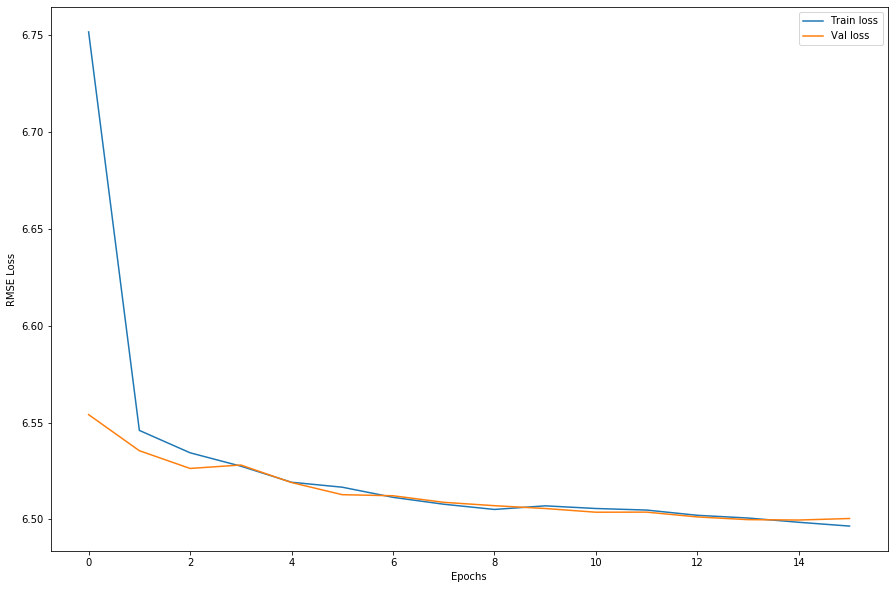

In [22]:
import matplotlib.pyplot as plt
epochs = np.arange(1,16)
plt.figure(figsize=(15,10)) 
plt.plot(train_losses)
plt.plot(val_losses)
plt.legend(['Train loss', 'Val loss'], loc='upper right')
plt.xlabel("Epochs")
plt.ylabel("RMSE Loss")
plt.show()

Evaluating the model

In [23]:
evaluator = Evaluator(model, criterion, test_loader, device)
test_loss = evaluator.evaluate()
loss_type = type(criterion).__name__
print(f'STConvS2S {loss_type}: {test_loss:.4f}')

STConvS2S RMSELoss: 6.4737


In [44]:
if (torch.cuda.is_available()):
    torch.cuda.empty_cache()

Notification via email

In [34]:
model_info = {'Jupyter': 'yes',
              'best_epoch': best_epoch,
              'val_error': val_loss,
              'test_error': test_loss,
              'loss_type': loss_type,
              'step': step,
              'e_layer': encoder_layer_size,
              'e_kernel_size': kernel_size,
              'e_filter': filter_size,
              'd_layer': decoder_layer_size,
              'd_kernel_size': kernel_size,
              'd_filter': filter_size,
              'dropout_rate': dropout_rate,
              'dataset': dataset,
              'hostname': platform.node()}

model_info

{'Jupyter': 'yes',
 'best_epoch': 48,
 'val_error': 6.446622056620462,
 'test_error': 6.406130501202175,
 'loss_type': 'RMSELoss',
 'step': 5,
 'e_layer': 2,
 'e_kernel_size': 3,
 'e_filter': 64,
 'd_layer': 2,
 'd_kernel_size': 3,
 'd_filter': 64,
 'dropout_rate': 0.2,
 'dataset': '../data/dataset-chirps-1981-2019-seq5-ystep5.nc',
 'hostname': 'LAPTOP-5O8KK05N'}

In [24]:
util.send_email(model_info)

2153.3084013462067
email sent
